In [1]:
import matplotlib.pyplot as plt
from jax import vmap, grad, jit
import jax.numpy as jnp
import numpy as np

import scipy.io
import balltree as bt


def jax_build_balltree(data: jnp.ndarray, batch_idx: jnp.ndarray):
    return tuple(jnp.array(a) for a in bt.build_balltree_with_idx(np.asarray(data), np.asarray(batch_idx)))

def jax_partition_balltree(data: jnp.ndarray, batch_idx: jnp.ndarray, num_partitions: int):
    return tuple(jnp.array(a) for a in bt.partition_balltree_with_idx(np.asarray(data), np.asarray(batch_idx), num_partitions))

def jax_build_balltree_hierarchy(data, batch_idx, ball_sizes):
    data = np.asarray(data)
    batch_idx = np.asarray(batch_idx)
    
    dim = data.shape[1]
    num_layers = len(ball_sizes)
    
    # Get leaves of the original tree
    #tree_idx, tree_mask = bt.build_balltree_with_idx(data, batch_idx)
    #leaves = data[tree_idx]
    #batch_idx = batch_idx[tree_idx]
    leaves = data
    
    # Number of partitions to do such that leaf balls contain necessary number of points
    # For example, if ball_sizes = [4, 8, 16] and number of data is 128,
    # Then target_partitions = [log2(32), log2(16), log2(8)] = [5, 4, 3] 
    # Meaning, we will partition into 6, 5, 4 and then 3 balls.
    target_partitions = [max(0, int(np.log2(leaves.shape[0] / bs))) for bs in ball_sizes]
    tree_indices = []
    #leaves_list = []
    for i in range(num_layers):
        tree_indices.append(bt.partition_balltree_with_idx(leaves, batch_idx, target_partitions[i]))
        #leaves_list.append(leaves)
        #if i < num_layers - 1:
            #leaves = np.mean(leaves.reshape((-1, ball_sizes[i], dim)), axis=1)
            #current_batch_idx = current_batch_idx[::ball_sizes[i]]
    return tree_indices, target_partitions


#help(bt.build_balltree_with_idx)

# Load matlab file
mat = scipy.io.loadmat('../data/Y25M08D21_mobility_study_1024_par.mat')
M = jnp.array(mat["M"])
q = jnp.array(mat["q"])
P = q.shape[0]
d = q.shape[1]
batch_idx = jnp.zeros((q.shape[0],), dtype=jnp.int32)

sizes = [2,4,8,16, 32]#,64]
tree_indices, target_partitions = jax_build_balltree_hierarchy(q, batch_idx, sizes)

Target ball size: 2. Actual ball size: 2. Number of splits: 6. Number of balls: 64
Target ball size: 4. Actual ball size: 4. Number of splits: 5. Number of balls: 32
Target ball size: 8. Actual ball size: 8. Number of splits: 4. Number of balls: 16
Target ball size: 16. Actual ball size: 16. Number of splits: 3. Number of balls: 8
Target ball size: 32. Actual ball size: 32. Number of splits: 2. Number of balls: 4


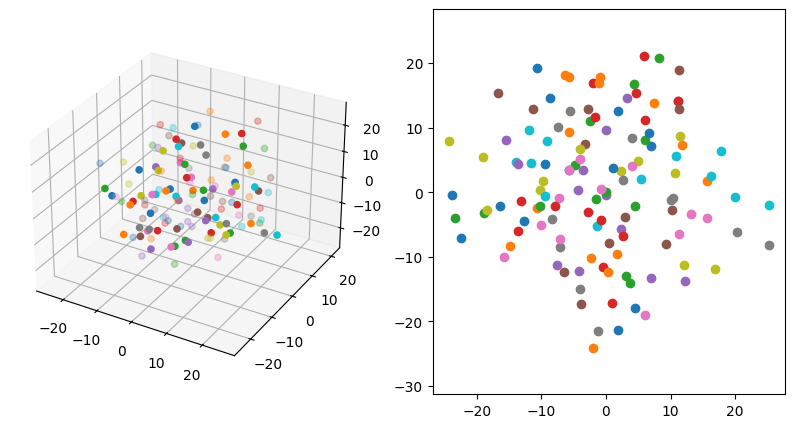

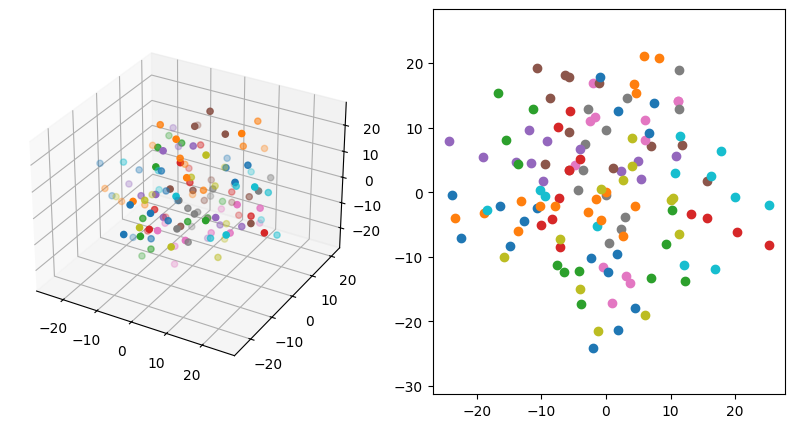

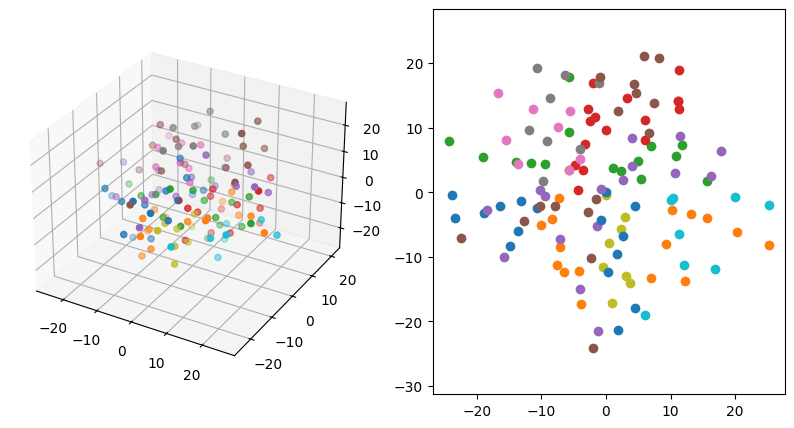

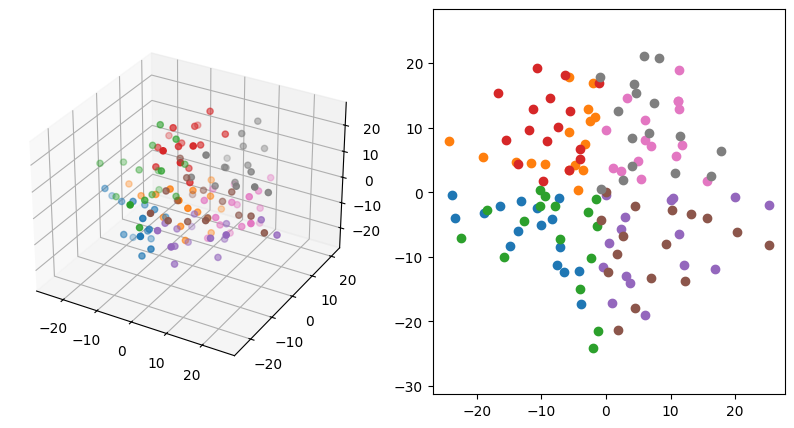

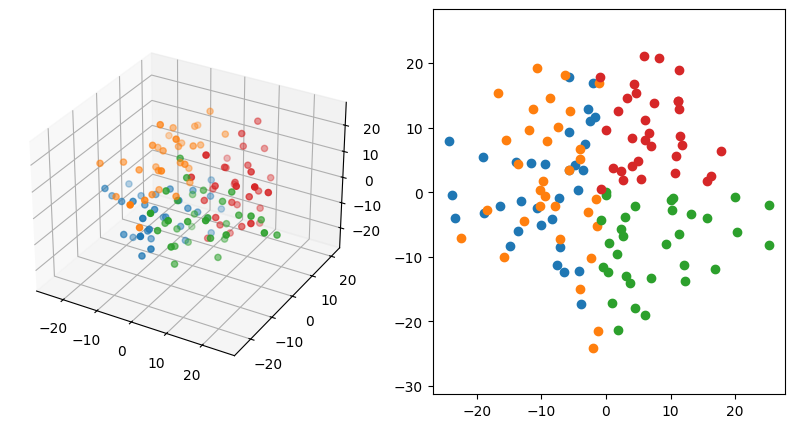

In [ ]:
interp = lambda a,b, t: a*t + b*(1-t)
for bs, tp, tree_idx_part in zip(sizes, target_partitions, tree_indices):
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(121, projection='3d')
    ax2 = plt.subplot(122)
    num_balls = 2 ** tp
    bs_actual = P // num_balls
    #bs_actual = 2 ** tp
    #num_balls = P // bs_actual
    idxj_part = tree_idx_part[:bs_actual]
    print(f"Target ball size: {bs}. Actual ball size: {bs_actual}. Number of splits: {tp}. Number of balls: {num_balls}")
    for i in range(num_balls):
        idx_part = tree_idx_part[bs_actual*i:bs_actual*(i+1)]
        qi_ball = q[idx_part, :]
        ax1.scatter(qi_ball[:,0], qi_ball[:,1], qi_ball[:,2])#, '*-')
        #col = interp(np.array([[1, 0, 0]]), np.array([0,1,0]), i/len(tree_idx)*2)
        #ax1.scatter(q_ball[:,0], q_ball[:,1], q_ball[:,2], c=np.repeat(col, 2, axis=0), s=100, alpha=0.5)
        plt.axis("equal")
        
        ax2.scatter(qi_ball[:,0], qi_ball[:,1])#, '*')
        plt.axis("equal")

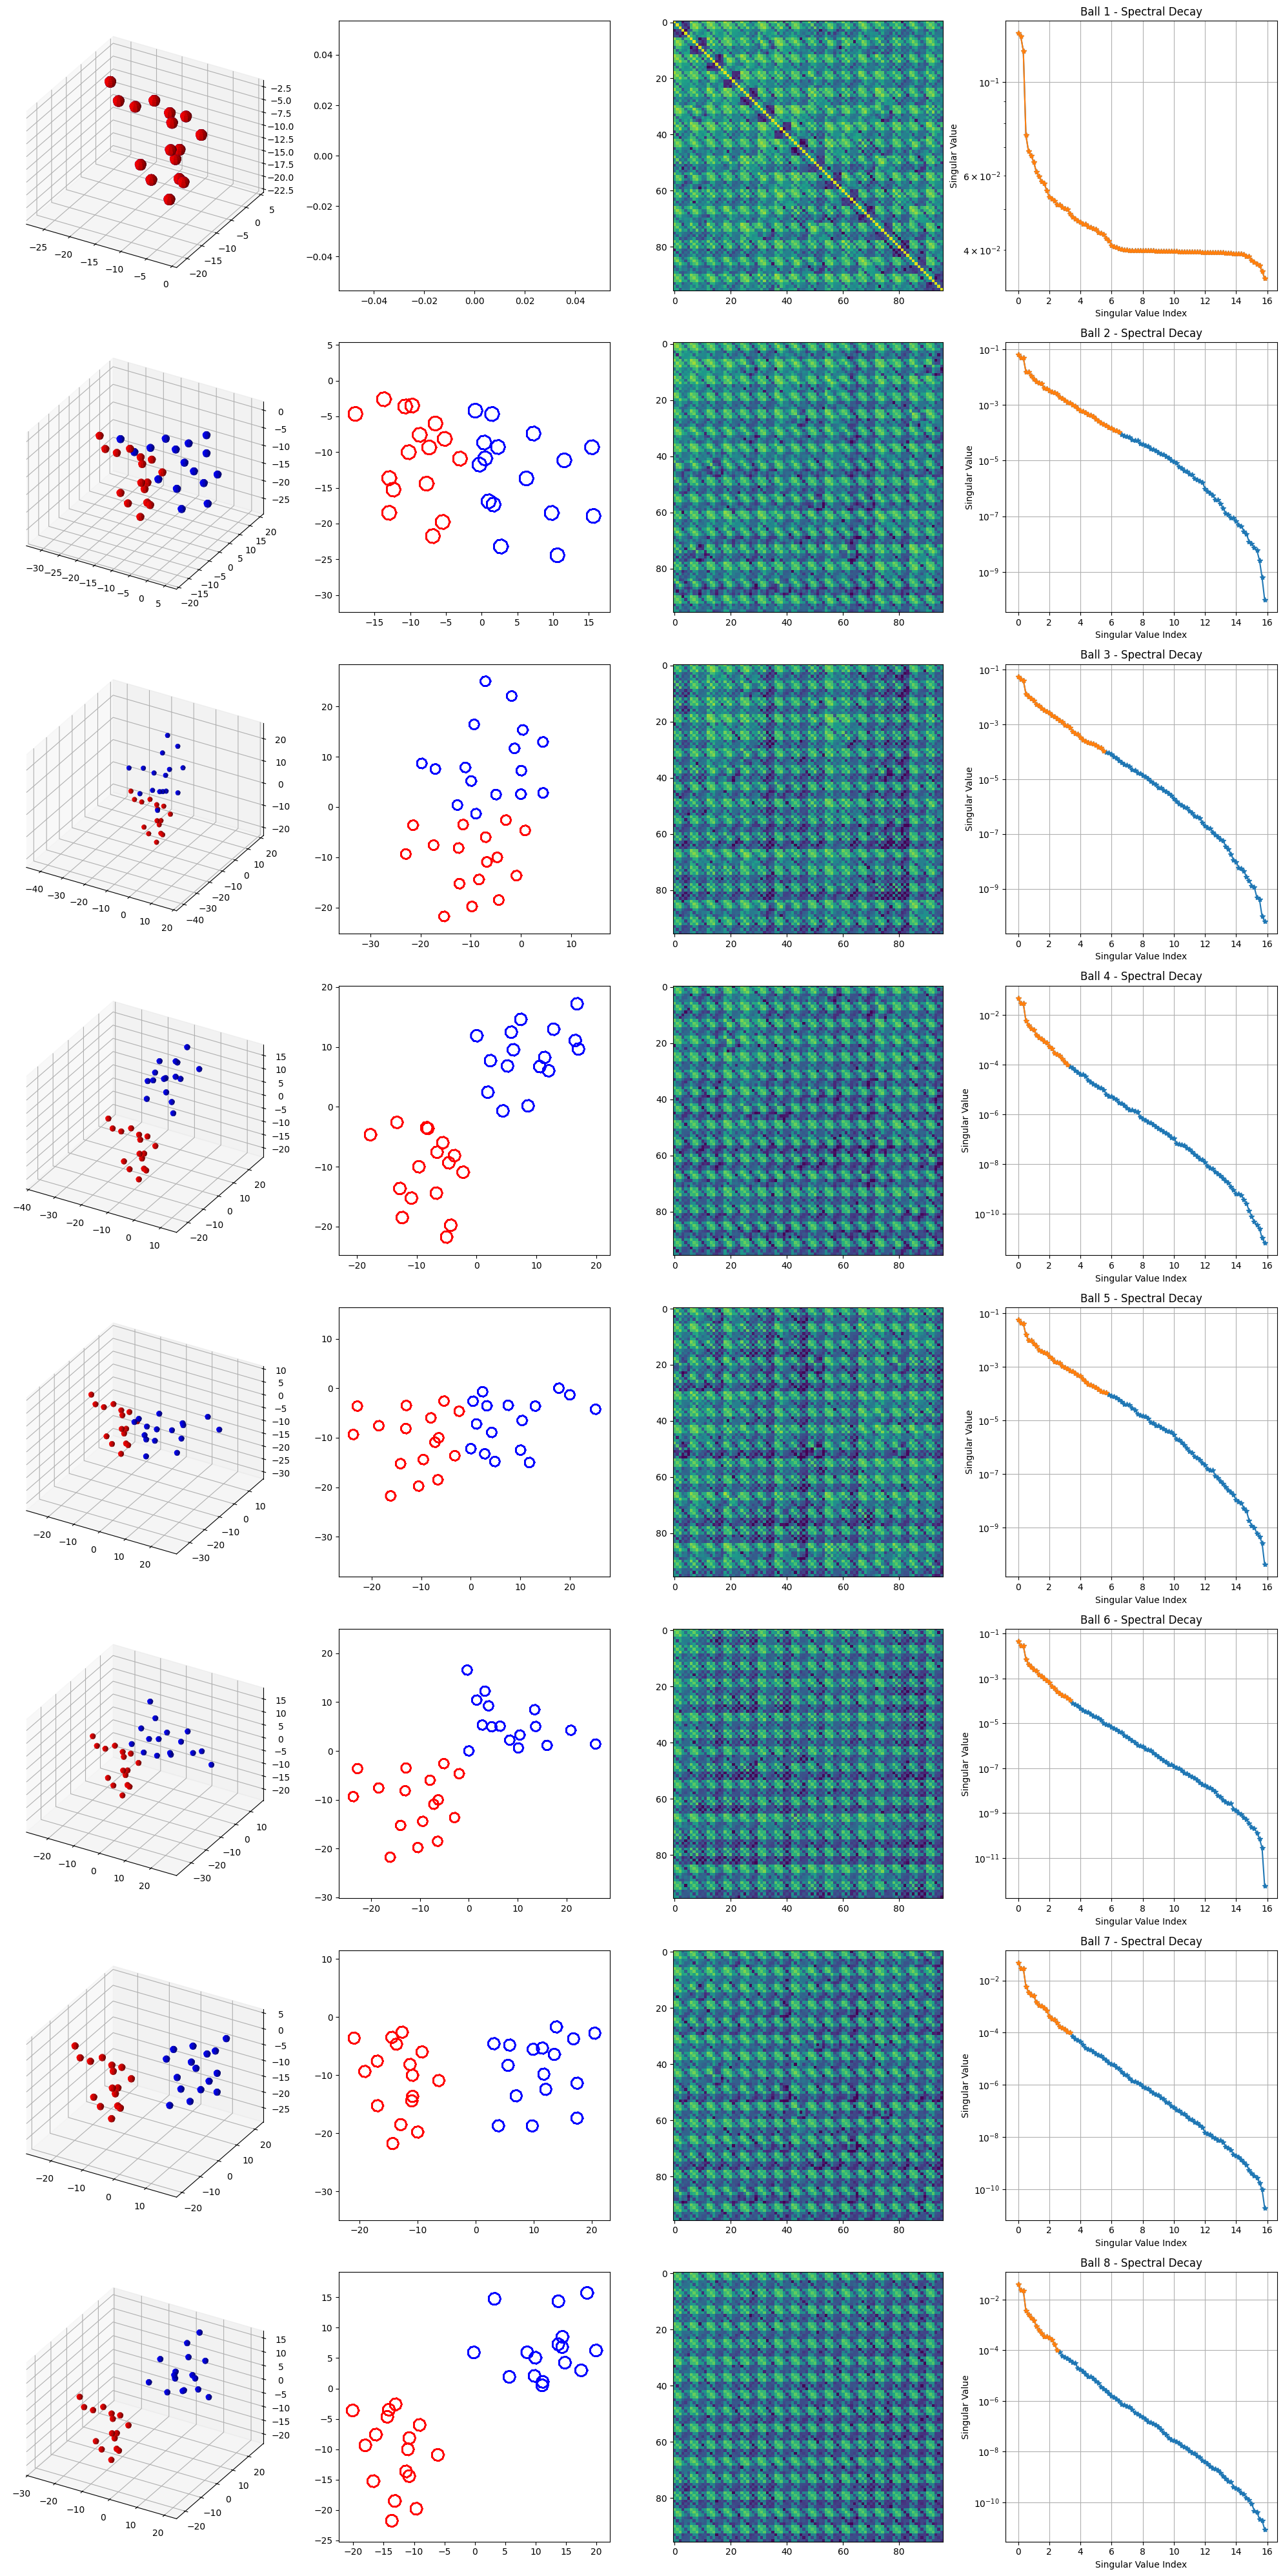

In [ ]:
def to_mat_idx(idx):
    return 6*np.repeat(idx, 6) + (np.arange(6*len(idx)) % 6)
    #return idx * 6

lvl = 3
bs = sizes[lvl]
tp = target_partitions[lvl]
tree_idx_part = tree_indices[lvl]
#for bs, tp, tree_idx_part in zip(sizes, target_partitions, tree_indices):

j = 0
num_balls = 2 ** tp
bs_actual = P // num_balls
#bs_actual = 2 ** tp
#num_balls = P // bs_actual
idxj_part = np.unique(tree_idx_part[j*bs_actual:(j+1)*bs_actual])
numj_part = len(idxj_part)
mat_idxj = to_mat_idx(idxj_part)
qj_ball = q[idxj_part, :]

def scatter_wrap(ax, q_ball, q0_ball):
    q0_mean = q0_ball.mean(axis=0)
    q_mean = q_ball.mean(axis=0)
    view_vec = q_mean - q0_mean
    view_vec = jnp.linalg.cross(view_vec, jnp.array([0, 0, 1]))
    view_vec = view_vec / jnp.linalg.norm(view_vec)# * jnp.sign(view_vec[2]) / jnp.linalg.norm(view_vec)
    up = np.array([0, 0, 1])
    r = np.cross(up, view_vec); r /= np.linalg.norm(r)  # right
    u = np.cross(view_vec, r)  # true up
    R = np.stack([r, u, -view_vec], axis=1)

    def tfm(q):
        q = jnp.einsum("ij,jk->ik", q, R)
        return q[:,0], q[:,1]

    for q,col in zip([q_ball, q0_ball], ["blue", "red"]):
        qx, qy = tfm(q)
        plot_circles(ax, qx, qy, color=col)
        #ax.scatter(qx, qy, s=50)
        
def plot_circles(ax, qx, qy, N=10, **kwargs):
    t = np.linspace(0, 2 * np.pi, N)
    x = np.outer(np.cos(t), np.ones_like(qx))
    y = np.outer(np.sin(t), np.ones_like(qy))
    for qxi,qyi in zip(qx, qy):
        ax.plot(qxi + x, qyi + y, **kwargs)

def plot_sphere(ax, q, N=10, **kwargs):
    # Make data
    u = np.linspace(0, 2 * np.pi, N)
    v = np.linspace(0, np.pi, N)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    # Plot the surface
    ax.plot_surface(q[0]+x, q[1]+y, q[2]+z, **kwargs)
    
def plot_spheres(ax, q_list, N=10, **kwargs):
    for q in q_list:
        plot_sphere(ax, q, N=N, **kwargs)

plt.figure(figsize=(20, 40))
for i in range(num_balls):
    
    idx_part = np.unique(tree_idx_part[bs_actual*i:bs_actual*(i+1)])
    num_part = len(idx_part)
    mat_idx = to_mat_idx(idx_part)
    assert len(np.intersect1d(idxj_part, idx_part))==0 or j == i
    
    
    qi_ball = q[idx_part, :]
    qi_mean = qi_ball.mean(axis=0)
    iG, jG = np.meshgrid(mat_idxj, mat_idx, indexing='ij')
    M_ball = M[iG.flatten(), jG.flatten()].reshape(iG.shape)
    

    ax1 = plt.subplot(num_balls, 4, 4*i+1, projection="3d")    
    plot_spheres(ax1, qi_ball, color="blue") #ax1.scatter(q_ball[:,0], q_ball[:,1], q_ball[:,2])
    plot_spheres(ax1, qj_ball, color="red") #ax1.scatter(qj_ball[:,0], qj_ball[:,1], qj_ball[:,2])
    ax1.set_proj_type('ortho')
    ax1.axis("equal")
    
    
    ax1p5 = plt.subplot(num_balls, 4, 4*i+2)
    scatter_wrap(ax1p5, qi_ball, qj_ball)
    ax1p5.axis("equal")

    ax2 = plt.subplot(num_balls, 4, 4*i+3)
    plt.imshow(jnp.log10(jnp.abs(M_ball)), vmin=-8, vmax=-1)
    
    
    ax3 = plt.subplot(num_balls, 4, 4*i+4)
    # Spectral decay:
    U, E, Vh  = np.linalg.svd(M_ball)
    #E  = np.cumsum(E[::-1])[::-1] / np.sum(E)
    ref_part = min(numj_part, num_part)
    tol = 1e-4
    t = np.arange(len(E)) / 6
    plt.semilogy(t, E, '*-')
    tidx = np.where(E > tol)[0]
    plt.semilogy(t[tidx], E[tidx], '*-')
    plt.title(f"Ball {i+1} - Spectral Decay")
    plt.xlabel("Singular Value Index")
    plt.ylabel("Singular Value")
    plt.grid()
    
plt.tight_layout()
plt.gcf().savefig("cluster_pairs.pdf", dpi=300)

In [49]:
tol = 1e-4
M_dim_list = []
M_tol_list = []
M_dist_list = []
M_width_list = []

dofs = [1,3,5,8]
num_dofs = len(dofs)


for lvl in range(len(sizes)):
    bs = sizes[lvl]
    tp = target_partitions[lvl]
    tree_idx_part = tree_indices[lvl]
    num_balls = 2 ** tp
    bs_actual = P // num_balls
    #bs_actual = 2 ** tp
    #num_balls = P // bs_actual
    
    M_dist = np.zeros((num_balls, num_balls))
    M_dim = np.zeros((num_balls, num_balls))
    M_tol = np.zeros((num_balls, num_balls, num_dofs))
    M_width = np.zeros((num_balls, num_balls))
    for j in range(num_balls):
        idxj_part = np.unique(tree_idx_part[bs_actual*j:bs_actual*(j+1)])
        numj_part = len(idxj_part)
        mat_idxj = to_mat_idx(idxj_part)
        qj_ball = q[idxj_part, :]
        qj_mean = np.mean(qj_ball, axis=0)

        for i in range(num_balls):
            idx_part = np.unique(tree_idx_part[bs_actual*i:bs_actual*(i+1)])
            num_part = len(idx_part)
            mat_idx = to_mat_idx(idx_part)
            assert len(np.intersect1d(idxj_part, idx_part))==0 or j == i
            
            
            qi_ball = q[idx_part, :]
            qi_mean = qi_ball.mean(axis=0)
            iG, jG = np.meshgrid(mat_idxj, mat_idx, indexing='ij')
            M_ball = M[iG.flatten(), jG.flatten()].reshape(iG.shape)
            U, E, Vh  = np.linalg.svd(M_ball)
            fac_dim = np.sum(jnp.where(E > tol, 1., 0.)) / len(E)
            M_dim[i, j] = fac_dim    
            for didx, dof in enumerate(dofs):
                M_tol[i, j, didx] = E[min(len(E)-1, 6*dof)] # 8*6

            radi = np.linalg.norm(qi_ball - qi_mean, axis=0).max()#std()
            radj = np.linalg.norm(qj_ball - qj_mean, axis=0).max()#std()
            distij = np.linalg.norm(qj_ball[:, None, :] - qi_ball[None, :, :], axis=-1).mean()
            
            M_dist[i, j] = np.linalg.norm(qj_mean - qi_mean)
            M_width[i, j] = max([radi, radj])#max(, np.linalg.norm(qi_ball - qi_mean, axis=0).max())

    M_dim_list.append(M_dim)
    M_tol_list.append(M_tol)
    M_dist_list.append(M_dist)
    M_width_list.append(M_width)


/tmp/ipykernel_1995884/260118265.py:12: RuntimeWarning: divide by zero encountered in divide
  im3 = ax3.imshow(M_width/M_dist, cmap="CMRmap")


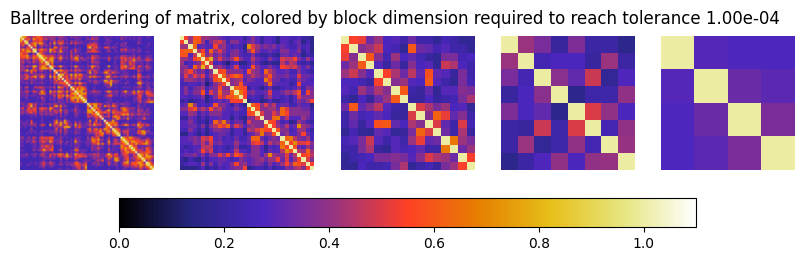

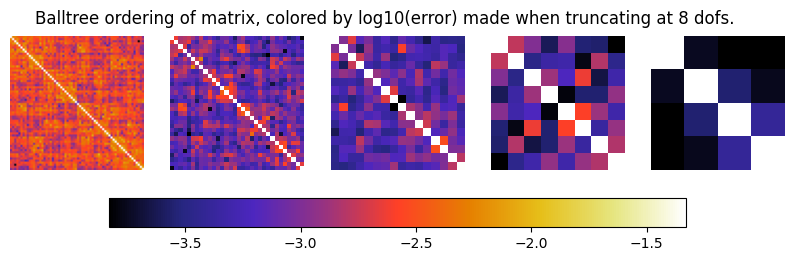

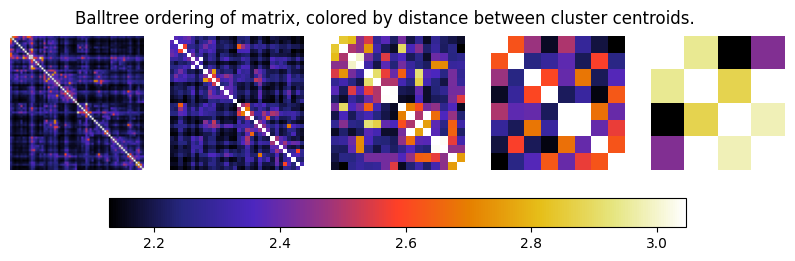

In [50]:

fig, axes = plt.subplots(nrows=1, ncols=len(sizes), figsize=(10, 2.5))    
fig2, axes2 = plt.subplots(nrows=1, ncols=len(sizes), figsize=(10, 2.5))    
fig3, axes3 = plt.subplots(nrows=1, ncols=len(sizes), figsize=(10, 2.5))

for lvl, M_dim, M_tol, M_dist, M_width, ax, ax2, ax3 in zip(range(len(sizes)), M_dim_list, M_tol_list, M_dist_list, M_width_list, axes.flat, axes2.flat, axes3.flat):
    im = ax.imshow(M_dim, vmin=0, vmax=1.1, cmap="CMRmap")
    ax.axis("off")
    
    im2 = ax2.imshow(jnp.log10(M_tol[:, :, -1]), cmap="CMRmap")
    ax2.axis("off")
    
    im3 = ax3.imshow(M_width/M_dist, cmap="CMRmap")
    ax3.axis("off")

fig.suptitle(f"Balltree ordering of matrix, colored by block dimension required to reach tolerance {tol:.2e}")
fig.colorbar(im, ax=axes.ravel().tolist(), orientation="horizontal")
#plt.tight_layout()
fig.savefig("mobility-factorisation-block-dim-dof.pdf", dpi=300)

fig2.suptitle(f"Balltree ordering of matrix, colored by log10(error) made when truncating at {dofs[-1]} dofs.")
fig2.colorbar(im2, ax=axes2.ravel().tolist(), orientation="horizontal")
#plt.tight_layout()
fig2.savefig("mobility-factorisation-block-dim-tol.pdf", dpi=300)

fig3.suptitle(f"Balltree ordering of matrix, colored by distance between cluster centroids.")
fig3.colorbar(im3, ax=axes3.ravel().tolist(), orientation="horizontal")
#plt.tight_layout()
fig3.savefig("mobility-factorisation-block-dim-dist.pdf", dpi=300)


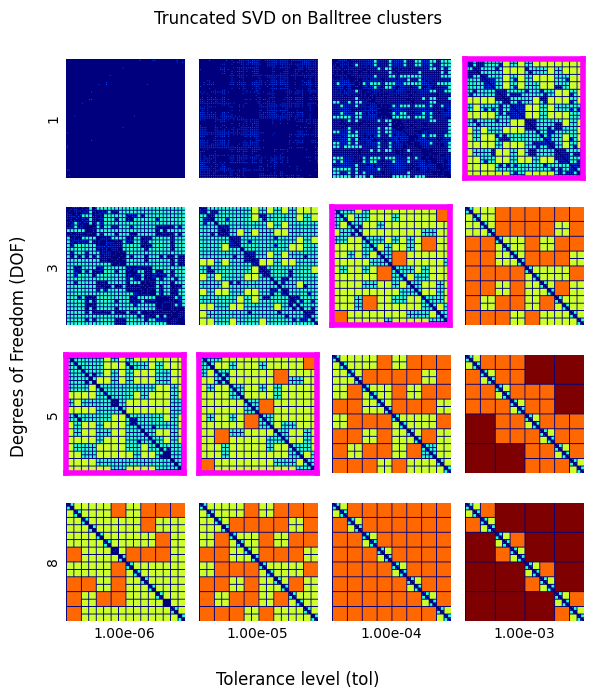

In [51]:

def extend(A, n):
    return np.repeat(np.repeat(A, n, axis=0), n, axis=1)

verbose = False
M_extend = []
for i in range(len(sizes)):
    tp = target_partitions[i]
    M_tol = M_tol_list[i]
    fac = 2**(6-tp) * 2
    M_tol = extend(M_tol, fac)
    M_extend.append(M_tol)

def cost(Mcost):
    return np.sum(Mcost)

#tol_list = [1e-6, 1e-5, 1e-4, 3e-4, 1e-3]
tol_list = [1e-6, 1e-5, 1e-4, 1e-3]
fig = plt.figure(figsize=(6,7))
for tidx, tol in enumerate(tol_list):
    min_cost_total = np.inf
    min_didx = -1
    for didx, dof in enumerate(dofs):
        
        M_class = np.zeros((P,P))
        M_mask = np.ones((P,P))
        #M_cost = np.zeros_like(M_extend[0][:,:,0])
        cost_total = 0
        if verbose:
            print("===================================")
            print(f"DOF: {dof}, tol: {tol:.2e}")
            print("===================================")
        tot_active = 0
        for i in range(len(sizes)-1, -2, -1):
            Mi = M_extend[i][:, :, didx]
            tp = target_partitions[i]

            #if i != 0:
            if i == -1:
                M_active = M_mask
                num_balls = P
                bs_actual = 1
            else:         
                M_meets_tol = Mi < tol
                M_active = M_meets_tol * M_mask
                M_mask = M_mask * (1 - M_meets_tol)
                       
                # For plotting purposes.
                n = 2**(6-tp) * 2
                I, J = np.meshgrid(np.arange(Mi.shape[0]), np.arange(Mi.shape[1]), indexing='ij')
                M_edge_mask = (I % (n) != 0) * (J % (n) != 0)
                M_class = M_class + M_active * M_edge_mask * (i + 1) # Classify elements of mobility matrix.
                       
                num_balls = 2 ** tp
                bs_actual = P // num_balls
            
            num_active = int(np.sum(M_active)/ P**2 * num_balls**2)
            tot_active = tot_active + num_active * bs_actual ** 2
            block_cost = min(6*dof, 6*bs_actual) * bs_actual * 6
            cost_active = num_active * block_cost
            cost_total = cost_total + cost_active
            
            if verbose:
                print(f"lvl {i+1}, {P} part split {tp} times -> {num_balls} balls of size {bs_actual} part.")
                print(f"with {dof} DOF, max dim {6*bs_actual} -> SVD trunc at {min(6*dof, 6*num_balls)} dim")
                print(f"At lvl {i}, {num_active} active blocks with {bs_actual**2*num_active} active pairs")
                print(f"With {num_active} active blocks, cost {block_cost} per block, total cost {cost_active}")
                print("")
                
        if verbose:
            print(f"In total: {tot_active} active pairs out of {P**2}, total cost {cost_total}")        
            
        if cost_total < min_cost_total:
            #print(f"tidx {tidx}, cost {cost_total} is better than {min_cost_total} at tidx {min_tidx}")
            min_didx = didx
            min_cost_total = cost_total 
            

        ax = plt.subplot(num_dofs, len(tol_list), len(tol_list)*didx + tidx + 1)
        if tidx == 0:
            plt.ylabel(f"{dof}")
        if didx == num_dofs-1:
            plt.xlabel(f"{tol:.2e}")
        #plt.title(f"{cost_total}", fontsize=8)
        ax.imshow(M_class, vmin=0, vmax=len(M_extend), cmap="jet")
        
        
        def cmap(val):
            cmap_ = plt.cm.inferno
            fac = 1.0
            maxval = 36*P*P
            minval = 36*P*40
            return cmap_((val - minval) / (maxval - minval))
        
        #for spine in ax.spines.values():
            #spine.set_visible(True)
            #spine.set_edgecolor(cmap(cost_total))
            #spine.set_linewidth(4)
        ax.spines[:].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])   

    # Highlight optimal partition by encircling border and title in red
    #print(f"Highlighting optimal partition at tidx {min_didx}")
    ax = plt.subplot(num_dofs, len(tol_list), len(tol_list)*min_didx + tidx + 1)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("magenta")
        spine.set_linewidth(4)
    #ax.set_title(f"{cost_total}", fontsize=8, color="magenta")

fig.suptitle("Truncated SVD on Balltree clusters")
fig.supylabel("Degrees of Freedom (DOF)")
fig.supxlabel("Tolerance level (tol)")
plt.tight_layout()
fig.savefig("mobility-factorisation.pdf", dpi=300)

/tmp/ipykernel_1995884/3736374191.py:9: RuntimeWarning: divide by zero encountered in divide
  M_frac = extend(M_width_list[i]/M_dist_list[i], fac)


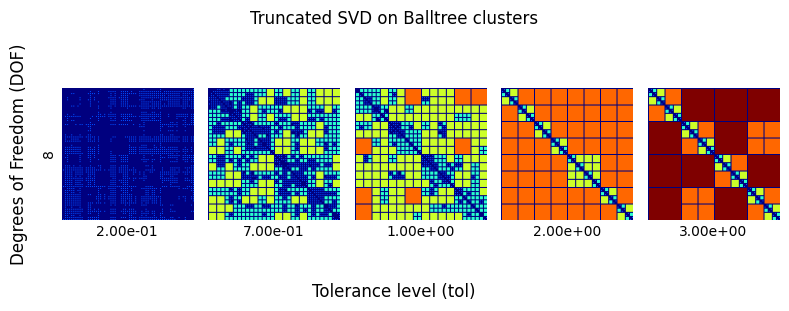

In [58]:

def extend(A, n):
    return np.repeat(np.repeat(A, n, axis=0), n, axis=1)

verbose = False
M_extend = []
for i in range(len(sizes)):
    tp = target_partitions[i]
    fac = 2**(6-tp) * 2
    M_frac = extend(M_width_list[i]/M_dist_list[i], fac)
    M_extend.append(M_frac)

def cost(Mcost):
    return np.sum(Mcost)

#tol_list = [1e-6, 1e-5, 1e-4, 3e-4, 1e-3]
#tol_list = [1e-6, 1e-5, 1e-4, 1e-3]
tol_list = [0.2, 0.7, 1.0, 2.0, 3.0]
fig = plt.figure(figsize=(8,3))
for tidx, tol in enumerate(tol_list):
    
    M_class = np.zeros((P,P))
    M_mask = np.ones((P,P))
    for i in range(len(sizes)-1, -2, -1):
        Mi = M_extend[i]
        tp = target_partitions[i]

        #if i != 0:
        if i == -1:
            M_active = M_mask
            num_balls = P
            bs_actual = 1
        else:         
            M_meets_tol = Mi < tol
            M_active = M_meets_tol * M_mask
            M_mask = M_mask * (1 - M_meets_tol)
                    
            # For plotting purposes.
            n = 2**(6-tp) * 2
            I, J = np.meshgrid(np.arange(Mi.shape[0]), np.arange(Mi.shape[1]), indexing='ij')
            M_edge_mask = (I % (n) != 0) * (J % (n) != 0)
            M_class = M_class + M_active * M_edge_mask * (i + 1) # Classify elements of mobility matrix.
                    
            num_balls = 2 ** tp
            bs_actual = P // num_balls
        
            

        ax = plt.subplot(1, len(tol_list), tidx + 1)
        if tidx == 0:
            plt.ylabel(f"{dof}")
        if didx == num_dofs-1:
            plt.xlabel(f"{tol:.2e}")
        #plt.title(f"{cost_total}", fontsize=8)
        ax.imshow(M_class, vmin=0, vmax=len(M_extend), cmap="jet")
        
        
        def cmap(val):
            cmap_ = plt.cm.inferno
            fac = 1.0
            maxval = 36*P*P
            minval = 36*P*40
            return cmap_((val - minval) / (maxval - minval))
        
        #for spine in ax.spines.values():
            #spine.set_visible(True)
            #spine.set_edgecolor(cmap(cost_total))
            #spine.set_linewidth(4)
        ax.spines[:].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])   

    #ax.set_title(f"{cost_total}", fontsize=8, color="magenta")

fig.suptitle("Truncated SVD on Balltree clusters")
fig.supylabel("Degrees of Freedom (DOF)")
fig.supxlabel("Tolerance level (tol)")
plt.tight_layout()
fig.savefig("mobility-factorisation.pdf", dpi=300)

# Cost of ball matrix computations

Given a set $X$ of $P$ particles, and $\{B_1^q,\dots,B_{n_q}^q\}$ be a partition of the particles into $n_q$ sets of size $2^q$. If there are $P=2^p$ particles in total and then $n_q = 2^{p-q}$. For each $q$, the partition is organized such that $B_{2j-1}^q, B_{2j}^q\subset B_{j}^{q+1}$. At the final level, $B_i^0$ are all atomic sets with one particles in each.

For two sets $B_1$, $B_2$ containg  $P$ particles each, the corresponding mobility block $M(B_1,B_2)$ is $6P\times 6P$. Let $\sigma_n(B_1,B_2)$ denote the singular values, and for a given $n$, let $DOF=n/6$ denote the equivalent cluster size for a truncated SVD with cutoff $n$. The truncated factorization can be computed in $6P\cdot n = 36 P \cdot DOF$ flops. Let $J(\tau, q, DOF)=\{i,j\in \{1,\dots,n_q\}\colon \sigma_{6DOF}(B_i^q, B_j^q)<\tau\}$ be the set containing all indices of pairs of sets at level $q$ whose $DOF$-degree factorizations result in an error of $\tau$. Given the sets $\{J(\tau, q, DOF)\}_{q=1}^Q$ for some max level $Q\leq \log_2(P)$, Let $J'(\tau, q, DOF)$ denote the number of sets not contained in the previous collection. I.e,

$$
    J'(\tau, q, DOF) = 
    \begin{cases}
        J(\tau, q, DOF),&\text{if $q=Q$}\\
        \{(i,j)\in \{1,2,\dots,n_0\}\colon (\eta(i),\eta(j))\not\in J(\tau,1,DOF)\},&\text{if $q=0$}\\
        \{(i,j)\in \{1,2,\dots,n_q\}\colon (i,j)\in J(\tau,q,DOF)\quad \text{and}\quad (\eta(i),\eta(j))\not\in J(\tau,q+1,DOF)\}, & \text{otherwise}
    \end{cases}
$$
where $\eta(i)$ is an index function:
$$
    \eta(i) = 
    \begin{cases}
        i/2,&\text{if $i$ is even}\\
        (i+1)/2,&\text{if $i$ is odd}.
    \end{cases}
$$
That maps $i$ onto its parent index. At the initial level $q=Q$, we include all $(i,j)$ that meet the criteria $\tau$. At the intermediate levels, we include $(i,j)$ only if they have not yet been used. At the final level, we include all unused particles. These bust be computed pairwise. The total cost of computing a truncated SVD can be written as 
$$
    \mathrm{cost}(\tau, DOF) = \sum_{q=1}^Q \left| J'(\tau, q, DOF)\right|\cdot \mathrm{min}(6DOF, 6P_q)\cdot 6P_q,
$$
where $P_q = 2^q$ is the number of particles in each set at level $q$.
